# Import

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# 创建数据集

In [2]:
words = open("../data/names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
chars = sorted(set("".join(words)))
stoi = { s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = { i: s for s, i in stoi.items() }
vocab_size = len(itos)

In [4]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")
    return X, Y

import random
random.seed(11)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size = 3
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

X.shape: torch.Size([182306, 3]), Y.shape: torch.Size([182306])
X.shape: torch.Size([22885, 3]), Y.shape: torch.Size([22885])
X.shape: torch.Size([22955, 3]), Y.shape: torch.Size([22955])


# 模型定义

In [5]:
class Linear:
    def __init__(self, fan_in: torch.Tensor, fan_out: torch.Tensor, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.001):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        self.training = True

    def __call__(self, x: torch.Tensor):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x: torch.Tensor):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# 初始化模型参数

In [6]:
n_embd = 10
n_hidden = 100

g = torch.Generator().manual_seed(11)
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(       n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(       n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(       n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(       n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(       n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"模型参数量: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

模型参数量: 47024


# 训练

In [7]:
max_steps = 200000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb] # (32, 3, 2)
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track
    if i % 10000 == 0:
        print(f"{i}/{max_steps}: {loss.item()}")
    lossi.append(loss.item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 100000:
        break

0/200000: 3.316254138946533
10000/200000: 2.2083215713500977
20000/200000: 2.1597330570220947
30000/200000: 1.8775384426116943
40000/200000: 1.992132306098938
50000/200000: 1.9295384883880615
60000/200000: 2.0731093883514404
70000/200000: 2.00087833404541
80000/200000: 2.2567191123962402
90000/200000: 2.303598403930664
100000/200000: 2.086155652999878


# 中间层的分布

## 1. Tanh层输出

layer 2(Tanh      ): mean 0.00, std 0.68, saturated 14.45%
layer 5(Tanh      ): mean -0.01, std 0.72, saturated 16.06%
layer 8(Tanh      ): mean -0.01, std 0.75, saturated 16.23%
layer 11(Tanh      ): mean 0.01, std 0.78, saturated 17.03%
layer 14(Tanh      ): mean 0.01, std 0.81, saturated 20.25%


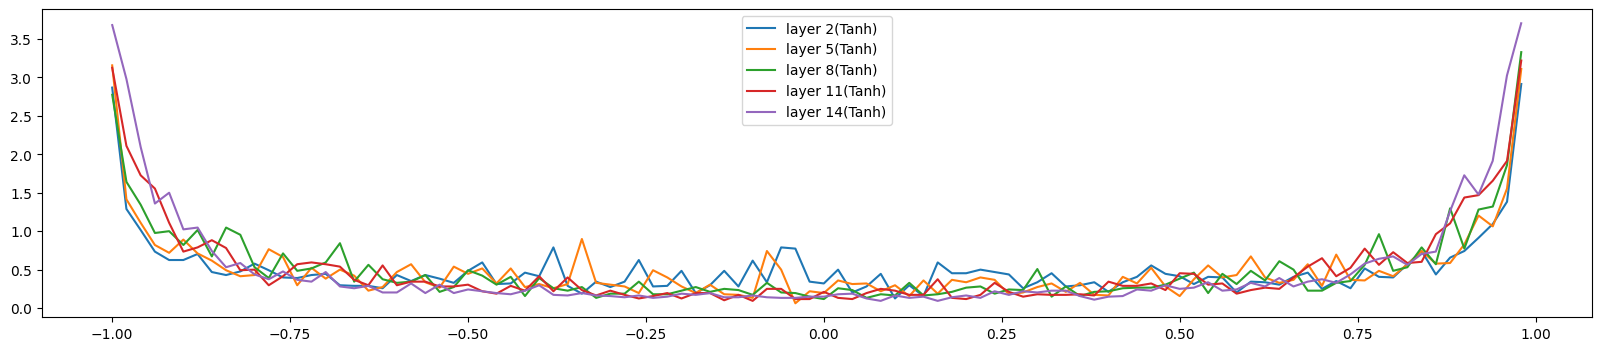

In [8]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i}({layer.__class__.__name__:10s}): mean {t.mean().item():.2f}, std {t.std().item():.2f}, saturated {(t.abs() > 0.97).float().mean().item() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {i}({layer.__class__.__name__})")
plt.legend()
plt.show()

## 2. Tanh层梯度

layer 2(Tanh      ): mean 0.0, std 0.002422736957669258
layer 5(Tanh      ): mean 1.3969838306981952e-11, std 0.0021800517570227385
layer 8(Tanh      ): mean 6.111804205094495e-12, std 0.0021262664813548326
layer 11(Tanh      ): mean -2.328306384496992e-12, std 0.001984260743483901
layer 14(Tanh      ): mean -5.529727717390465e-12, std 0.0021536864805966616


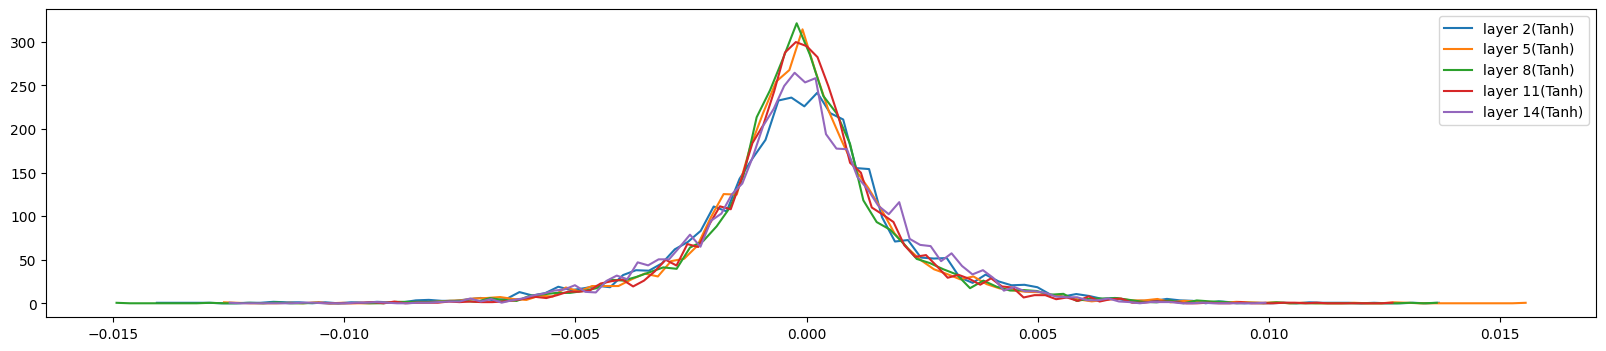

In [9]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i}({layer.__class__.__name__:10s}): mean {t.mean().item()}, std {t.std().item()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {i}({layer.__class__.__name__})")
plt.legend()
plt.show()

## 3. 模型权重的梯度

weight shape:(27, 10) | grad mean: -2.207579397062176e-10 | grad std: 0.017322426661849022 | grad:data ratio: 0.015558445990546366
weight shape:(30, 100) | grad mean: 3.6607696529245004e-05 | grad std: 0.00903938990086317 | grad:data ratio: 0.023301646744251347
weight shape:(100, 100) | grad mean: 4.7808964154683053e-05 | grad std: 0.005624889861792326 | grad:data ratio: 0.023309022456640755
weight shape:(100, 100) | grad mean: 1.429198709956836e-05 | grad std: 0.005461252760142088 | grad:data ratio: 0.023054138813921564
weight shape:(100, 100) | grad mean: 2.1972895410726778e-05 | grad std: 0.005220374558120966 | grad:data ratio: 0.02239319781190165
weight shape:(100, 100) | grad mean: -8.230037565226667e-06 | grad std: 0.004764387384057045 | grad:data ratio: 0.02129188994954197
weight shape:(100, 27) | grad mean: -8.183552563423291e-05 | grad std: 0.008856184780597687 | grad:data ratio: 0.02819607835695387


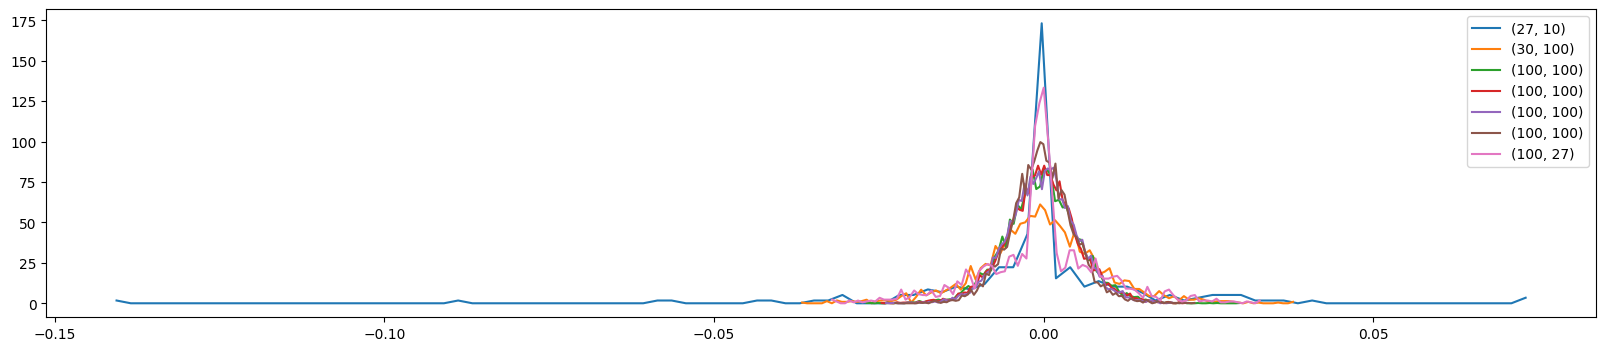

In [10]:
plt.figure(figsize=(20, 4))
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight shape:{tuple(p.shape)} | grad mean: {t.mean().item()} | grad std: {t.std().item()} | grad:data ratio: {t.std().item()/p.std().item()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"{tuple(p.shape)}")
plt.legend()
plt.show()

## 4. 模型权重更新量比权重

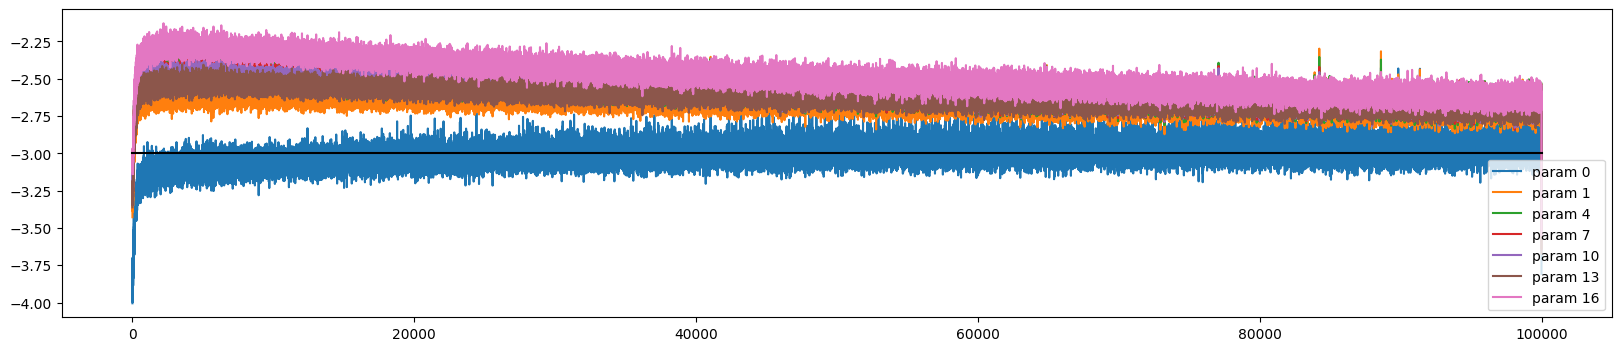

In [11]:
plt.figure(figsize=(20, 4))
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))], label=f"param {i}")
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend()
plt.show()

# 分布变化

- 两个标准正太分布的乘积的方差为1：https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables

- n个正太分布的均值为各个分布均值的和，方差为各个分布方差的和：https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables

- 所以两个标准正太分布矩阵相乘的分布，均值为0，方差为矩阵的第二个维度，即事例中的10

- 此后经过激活函数，如tanh，会导致大部分的值为1或者-1，梯度为0

- 为了保证矩阵相乘的分布方差仍为1，则需要乘以 $\sqrt{10}$

x_mean: 0.004877887666225433, x_std: 1.0012702941894531
y_mean: -0.0005345697863958776, x_std: 0.9815409779548645


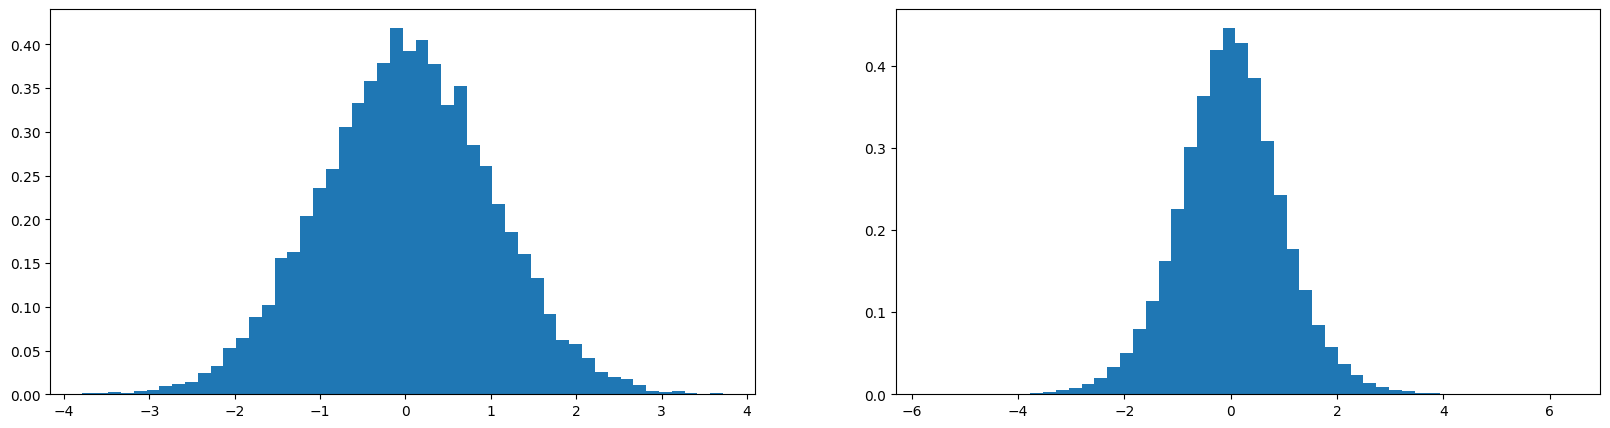

In [12]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(f"x_mean: {x.mean().item()}, x_std: {x.std().item()}")
print(f"y_mean: {y.mean().item()}, x_std: {y.std().item()}")
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

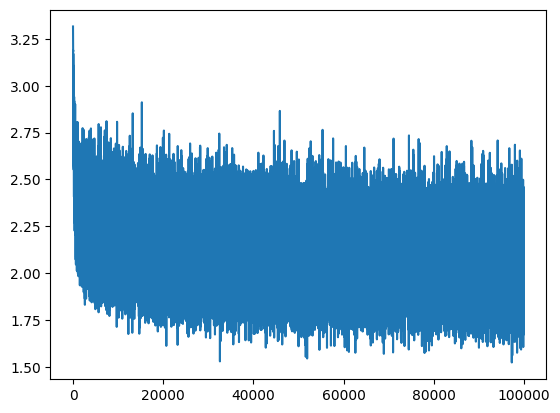

In [13]:
plt.plot(range(len(lossi)), lossi)

# 训练效果

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (32, 3, 2)
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)

    print(f"{split} loss: {loss.item()}")

for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")
split_loss("test")

train loss: 2.01468825340271
val loss: 2.1008846759796143
test loss: 2.103975772857666


# Embedding可视化

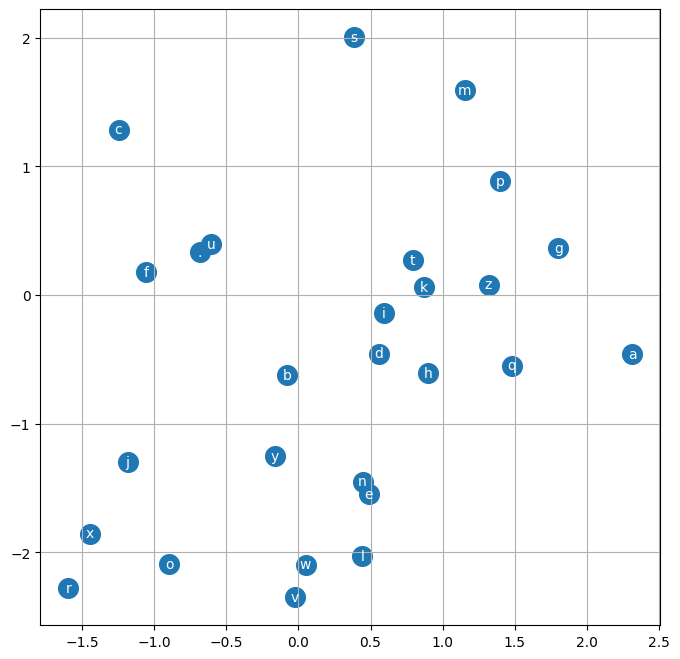

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

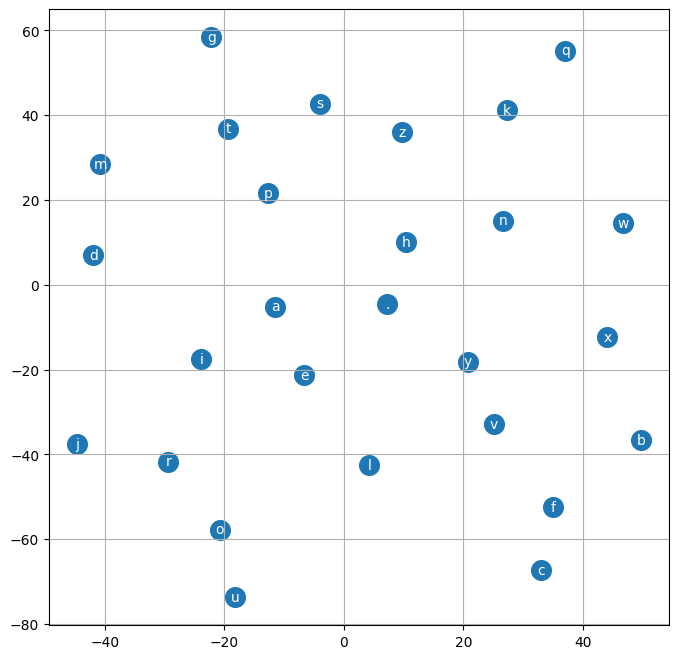

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=10)
tsne_emb = tsne.fit_transform(C.data.numpy())

plt.figure(figsize=(8, 8))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=200)
for i in range(tsne_emb.shape[0]):
    plt.text(tsne_emb[i, 0], tsne_emb[i, 1], itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# 使用模型生成名字

In [17]:
sample_size = 20

g = torch.Generator().manual_seed(11 + 10)

for _ in range(sample_size):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(-1, n_embd * block_size)
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print("".join([itos[i] for i in out]))

athekiel
cremina
hen
jera
taoppinchael
natin
zoer
tia
emik
avaan
jadiago
knia
giangernii
stan
ben
ick
valeigi
comier
levier
rudy
